In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
from tqdm.notebook import tqdm
from PIL import Image
import os

In [5]:
from torchinfo import summary

### read images

In [6]:
path = r'C:\Users\liuya\Downloads\3d_printing_research\clipped_samples_otsu'
## path = r'C:\Users\liuya\Downloads\3d_printing_research\clipped_samples'
image_list = os.listdir(path)

In [7]:
full_path = os.path.join(path, image_list[350])
np.array(Image.open(full_path).convert('RGB')).shape

(250, 730, 3)

In [8]:
image_ls = []

for i in tqdm(image_list):
    full_path = os.path.join(path, i)
    img = Image.open(full_path).convert('L')
    img_array = np.asarray(img).flatten()
    image_ls.append(img_array)

  0%|          | 0/4046 [00:00<?, ?it/s]

In [9]:
### normalize
data_input = np.array(image_ls)

In [10]:
data_input.shape

(4046, 182500)

In [11]:
data_input = np.divide((data_input-np.min(data_input)), (np.max(data_input)-np.min(data_input)))

In [12]:
## data_input = torch.tensor(data_input[:,None,:,:], dtype=torch.float32)
data_input = torch.tensor(data_input, dtype=torch.float32)

### build the model

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encoder = nn.Sequential(
            ## 250*730=182500
            nn.Linear(250*730, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 6))

        self.decoder = nn.Sequential(
            nn.Linear(6,32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 182500),
            nn.Sigmoid())
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
model = Autoencoder()

### train the model

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    
    model.train() #trian model
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        ##calculate loss
        ##loss = 0
        ##for i in range(data.shape[0]):
            ##loss += F.mse_loss(output[i], data[i], reduction='sum')
        ##loss /= data.shape[0]
        loss = F.binary_cross_entropy(output, data)
        loss.backward()
        optimizer.step()
        # print result every 10 batch
        if batch_idx % 10 == 0:
            print('Train Epoch: {} ... Batch: {} ... Loss: {:.8f}'.format(epoch, batch_idx, loss))

In [16]:
def test(model, device, test_loader):
    model.eval() #evaluate model
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            #calculate sum loss
            test_loss += F.mse_loss(output, data, reduction='sum').item()
    
        test_loss /= len(test_loader.dataset)
        print('------------------- Test set: Average loss: {:.4f} ... Samples: {}'.format(test_loss, len(test_loader.dataset)))

### train and test split

In [17]:
train_window_, val_window_ = train_test_split(data_input, test_size=0.2, random_state=2022)

In [18]:
train_window_.shape

torch.Size([3236, 182500])

In [19]:
train_loader = torch.utils.data.DataLoader(train_window_, batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_window_, batch_size=16,shuffle=False)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
model = model.to(device)

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [36]:
epochs = 10

In [37]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 ... Batch: 0 ... Loss: 0.00641742
Train Epoch: 1 ... Batch: 10 ... Loss: 0.00466862
Train Epoch: 1 ... Batch: 20 ... Loss: 0.00501123
Train Epoch: 1 ... Batch: 30 ... Loss: 0.00644961
Train Epoch: 1 ... Batch: 40 ... Loss: 0.00556561
Train Epoch: 1 ... Batch: 50 ... Loss: 0.00551776
Train Epoch: 1 ... Batch: 60 ... Loss: 0.00663645
Train Epoch: 1 ... Batch: 70 ... Loss: 0.00629023
Train Epoch: 1 ... Batch: 80 ... Loss: 0.00547539
Train Epoch: 1 ... Batch: 90 ... Loss: 0.00621973
Train Epoch: 1 ... Batch: 100 ... Loss: 0.00652319
Train Epoch: 1 ... Batch: 110 ... Loss: 0.00504426
Train Epoch: 1 ... Batch: 120 ... Loss: 0.00587631
Train Epoch: 1 ... Batch: 130 ... Loss: 0.00572130
Train Epoch: 1 ... Batch: 140 ... Loss: 0.00599729
Train Epoch: 1 ... Batch: 150 ... Loss: 0.00661608
Train Epoch: 1 ... Batch: 160 ... Loss: 0.00523627
Train Epoch: 1 ... Batch: 170 ... Loss: 0.00524379
Train Epoch: 1 ... Batch: 180 ... Loss: 0.00527165
Train Epoch: 1 ... Batch: 190 ... Loss: 0.

Train Epoch: 8 ... Batch: 60 ... Loss: 0.00598000
Train Epoch: 8 ... Batch: 70 ... Loss: 0.00460467
Train Epoch: 8 ... Batch: 80 ... Loss: 0.00480274
Train Epoch: 8 ... Batch: 90 ... Loss: 0.00638244
Train Epoch: 8 ... Batch: 100 ... Loss: 0.00546440
Train Epoch: 8 ... Batch: 110 ... Loss: 0.00701838
Train Epoch: 8 ... Batch: 120 ... Loss: 0.00432357
Train Epoch: 8 ... Batch: 130 ... Loss: 0.00532508
Train Epoch: 8 ... Batch: 140 ... Loss: 0.00606679
Train Epoch: 8 ... Batch: 150 ... Loss: 0.00693002
Train Epoch: 8 ... Batch: 160 ... Loss: 0.00511992
Train Epoch: 8 ... Batch: 170 ... Loss: 0.00564622
Train Epoch: 8 ... Batch: 180 ... Loss: 0.00472225
Train Epoch: 8 ... Batch: 190 ... Loss: 0.00555676
Train Epoch: 8 ... Batch: 200 ... Loss: 0.00506825
------------------- Test set: Average loss: 451.2267 ... Samples: 810
Train Epoch: 9 ... Batch: 0 ... Loss: 0.00522593
Train Epoch: 9 ... Batch: 10 ... Loss: 0.00602450
Train Epoch: 9 ... Batch: 20 ... Loss: 0.00511509
Train Epoch: 9 ... B

In [38]:
### save the model
### torch.save(model.state_dict(), 'fully_connected_network_bceloss.pth')

### test the result

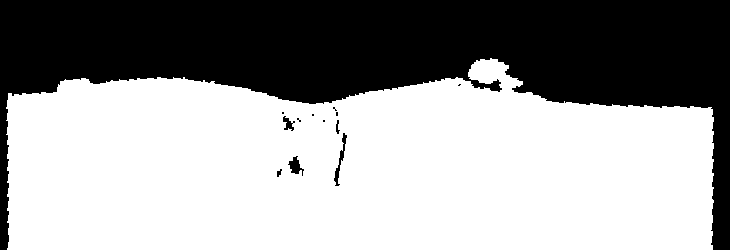

In [39]:
## cut the image
original = data_input[237].numpy().reshape((250,730))*255
Image.fromarray(original.astype('uint8'), 'L')

In [40]:
model.eval() #evaluate model
with torch.no_grad():
    data = data_input[237]
    #data = data[None,:,:,:]
    data = data.to(device)
    output = model(data)
    output = output.cpu()

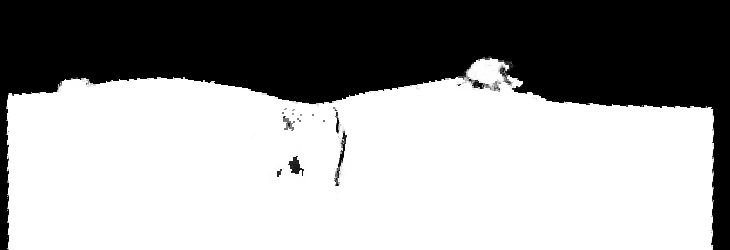

In [41]:
predict = output.numpy().reshape((250,730))*255
Image.fromarray(predict.astype('uint8'), 'L')

### reload and test

In [42]:
data_input.shape

torch.Size([4046, 182500])

In [16]:
model.load_state_dict(torch.load('fully_connected_network_bceloss.pth'))

<All keys matched successfully>

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [43]:
## extract encoder layers by hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [44]:
model.encoder.register_forward_hook(get_activation('encoder'))

In [45]:
extract_rlt = []

for i in tqdm(range(data_input.shape[0])):
    data = data_input[i]
    data = data.to(device)
    output = model(data)
    encoder_ = activation['encoder'].cpu().numpy()
    extract_rlt.append(encoder_)

  0%|          | 0/4046 [00:00<?, ?it/s]

In [46]:
ext_rlt = np.array(extract_rlt)

### projection

In [47]:
# try pca to reduce dimension
from sklearn.decomposition import PCA

In [48]:
label = np.load('label_01.npy')
color = ['green' if i==0 else 'red' for i in label]

In [49]:
#### pca

In [64]:
pca = PCA(n_components=3)
pca.fit(ext_rlt)

PCA(n_components=3)

In [65]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

[0.42861414 0.29785213 0.19503485]
[32366.53  22492.117 14727.935]


In [66]:
valid_ = pca.transform(ext_rlt)

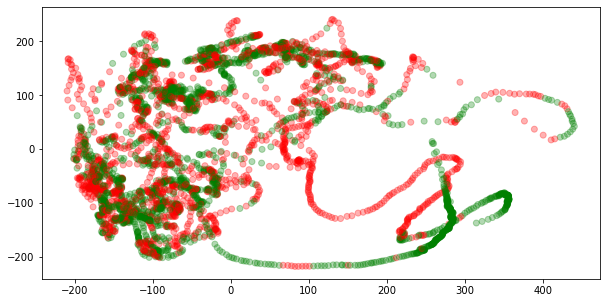

In [68]:
plt.figure(figsize=(10,5))
plt.scatter(valid_[:, 1], valid_[:, 2],marker='o', alpha=0.3, color=color)
plt.show()

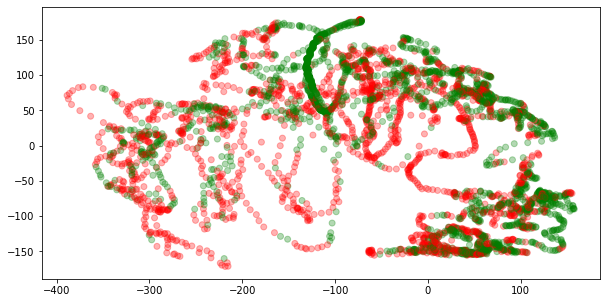

In [76]:
plt.figure(figsize=(10,5))
plt.scatter(ext_rlt[:, 0], ext_rlt[:, 2],marker='o', alpha=0.3, color=color)
plt.show()

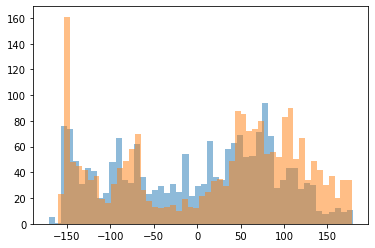

In [105]:
plt.hist(ext_rlt[:,2][np.where(np.array(label) == 1)[0]], bins=50, alpha=0.5)
plt.hist(ext_rlt[:,2][np.where(np.array(label) == 0)[0]], bins=50, alpha=0.5)
plt.show()

In [93]:
ext_rlt[:,5][np.where(np.array(label) == 1)[0]]

array([-91.37883 , -92.07171 , -96.02877 , ..., -44.775005, -32.76964 ,
       -21.21356 ], dtype=float32)

In [59]:
ext_rlt[0,20], ext_rlt[237,20]

(7.0498376, 18.428099)

In [53]:
#### kernel pca

In [55]:
from sklearn.decomposition import KernelPCA as kpca

In [60]:
pca = kpca(n_components=2, kernel='rbf')
pca.fit(ext_rlt)

KernelPCA(kernel='rbf', n_components=2)

In [61]:
valid_ = pca.transform(ext_rlt)

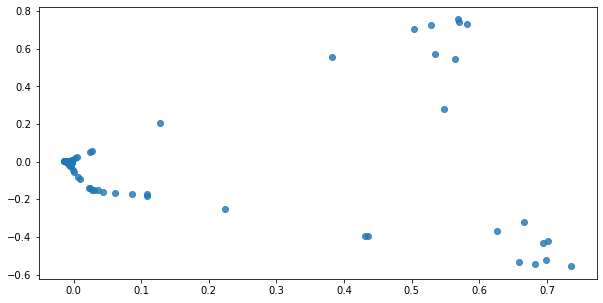

In [64]:
plt.figure(figsize=(10,5))
plt.scatter(valid_[:, 0], valid_[:, 1],marker='o', alpha=0.8)
plt.show()

### using mean

In [65]:
step = 5

def sliding_window(datas,steps=1,width=step):
    win_set=[]
    for i in tqdm(np.arange(0,len(datas),steps)):
        temp=datas[i:i+width]
        if temp.shape[0] == width:
            win_set.append(temp.mean())
    return np.array(win_set)

In [66]:
mean_rlt = sliding_window(ext_rlt,steps=5,width=step)

  0%|          | 0/810 [00:00<?, ?it/s]

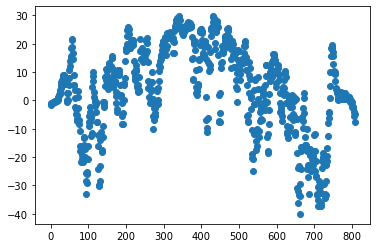

In [67]:
plt.scatter(range(mean_rlt.shape[0]), mean_rlt)
plt.show()

### save features

In [66]:
## extract encoder layers by hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [67]:
model.encoder.register_forward_hook(get_activation('encoder'))

In [68]:
extract_rlt = []

for i in tqdm(range(data_input.shape[0])):
    data = data_input[i]
    data = data.to(device)
    output = model(data)
    encoder_ = activation['encoder'].cpu().numpy()
    extract_rlt.append(encoder_)

  0%|          | 0/4046 [00:00<?, ?it/s]

In [72]:
np.save("extract_features.npy", np.array(extract_rlt))